# Asynchonous Processing

While many parallel applications can be described as maps, some can be more complex.
In this section we look at the asynchronous Future interface,
which provides a simple API for ad-hoc parallelism.
This is useful for when your computations don't fit a regular pattern.

## Download data

In [1]:
%rm -rf data/  # remove the data directory to restart execution

In [1]:
%%time
import datetime
import os, sys
from glob import glob
import pandas as pd
import dask
import dask.dataframe as dd
try:
    import ujson as json
except ImportError:
    import json


here = os.getcwd() # get the current directory
# create data and minute directories
os.makedirs(os.path.join(here, 'data', 'minute'), exist_ok=True)

stocks = ['hal', 'hp', 'hpq', 'ibm', 'jbl', 'jpm', 'luv', 'pcg','usb']

def write_stock(symbol):
    """ Get demo files from google using dask library and write some
    csv files """
    dirname = os.path.join(here, 'data', 'minute', symbol)
    today = datetime.datetime.now().date()
    year = datetime.timedelta(days=365)
    if not os.path.exists(dirname):
        os.mkdir(dirname)
        df = dd.demo.daily_stock(symbol, today - year, today, freq='30s',
                                 data_source='google')
        names = [str(ts.date()) for ts in df.divisions]
        df.to_csv(os.path.join(here, 'data', 'minute', symbol, '*.csv'),
                  name_function=names.__getitem__)
        print("Finished CSV: %s" % symbol)

for symbol in stocks:
    write_stock(symbol)


def convert_to_json(d):
    """ Convert all csv files of directory d into json format """
    filenames = sorted(glob(os.path.join(d, '*')))[-365:]
    outfn = d.replace('minute', 'json') + '.json'
    if os.path.exists(outfn):
        return
    with open(outfn, 'w') as f:
        for fn in filenames:
            df = pd.read_csv(fn)
            for rec in df.to_dict(orient='records'):
                json.dump(rec, f)
                f.write('\n')
    print("Finished JSON: %s" % d.split(os.path.sep)[-1])


js = os.path.join(here, 'data', 'json')
if not os.path.exists(js):
    os.mkdir(js)

directories = sorted(glob(os.path.join(here, 'data', 'minute', '*')))
for d in directories:
    convert_to_json(d)


CPU times: user 492 ms, sys: 78 ms, total: 570 ms
Wall time: 612 ms


In [2]:
import os, glob
filenames = sorted(glob.glob(os.path.join('data', 'json', '*.json')))
filenames

['data/json/hal.json',
 'data/json/hp.json',
 'data/json/hpq.json',
 'data/json/ibm.json',
 'data/json/jbl.json',
 'data/json/jpm.json',
 'data/json/luv.json',
 'data/json/pcg.json',
 'data/json/usb.json']

### Exercise 4.1
- Convert JSON data to HDF5 in parallel using `concurrent.futures`

In [4]:
%%time
import pandas as pd
import ujson as json # or json
for fn in filenames:
    with open(fn) as f:
        data = [json.loads(line) for line in f]
        
    df = pd.DataFrame(data)
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data')
    print("Finished : %s" % out_filename.split(os.path.sep)[-1])

Finished : hal.h5
Finished : hp.h5
Finished : hpq.h5
Finished : ibm.h5
Finished : jbl.h5
Finished : jpm.h5
Finished : luv.h5
Finished : pcg.h5
Finished : usb.h5
CPU times: user 5.09 s, sys: 738 ms, total: 5.82 s
Wall time: 5.94 s


## Application

Given our HDF5 files from the last section we want to find the two datasets with the greatest pair-wise correlation.  This forces us to consider all $n\times(n-1)$ possibilities.


In [5]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'json', '*.h5')))
filenames

['data/json/hal.h5',
 'data/json/hp.h5',
 'data/json/hpq.h5',
 'data/json/ibm.h5',
 'data/json/jbl.h5',
 'data/json/jpm.h5',
 'data/json/luv.h5',
 'data/json/pcg.h5',
 'data/json/usb.h5']

In [7]:
series ={}
for fn in filenames:
    series[fn] = pd.read_hdf(fn)['close']

In [8]:
%%time

results = {}

for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
            
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
print("%s matches with %s with correlation %f" % (a, b, corr))

data/json/jbl.h5 matches with data/json/pcg.h5 with correlation 0.946001
CPU times: user 254 ms, sys: 3.79 ms, total: 257 ms
Wall time: 256 ms


We use matplotlib to visually inspect the highly correlated timeseries

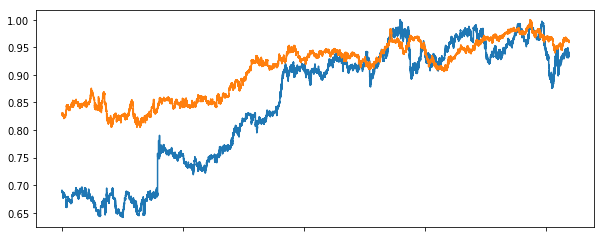

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(series[a]/series[a].max())
plt.plot(series[b]/series[b].max())
plt.xticks(visible=False);

## Analysis

This computation starts out by loading data from disk. We already know how to parallelize it:

```python
series = {}
for fn in filenames:
    series[fn] = pd.read_hdf(fn)['x']
```

It follows with a doubly nested for loop with an if statement.  

```python
results = {}
for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
```

It *is* possible to solve this problem with `map`, but it requires some cleverness.  Instead we'll learn `submit`, an interface to start individual function calls asynchronously.

It finishes with a reduction on small data.  This part is fast enough.

```python
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
```

### Executor.submit

The `submit` method starts a computation in a separate thread or process and immediately gives us a `Future` object that refers to the result.  At first, the future is pending.  Once the function completes the future is finished. 

We collect the result of the task with the `.result()` method,
which does not return until the results are available.

In [3]:
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)

from time import sleep

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

future = e.submit(slowadd, 1, 2)
future

<Future at 0x10c5c3208 state=running>

In [4]:
future.result()

3

### Submit many tasks, receive many futures

Because submit returns immediately we can submit many tasks all at once and they will execute in parallel.

In [5]:
%%time
results = [slowadd(i, i, delay=1) for i in range(10)]

CPU times: user 1.16 ms, sys: 1.31 ms, total: 2.47 ms
Wall time: 10 s


In [6]:
%%time
futures = [e.submit(slowadd, 1, 1, delay=1) for i in range(10)]
results = [f.result() for f in futures]

CPU times: user 2.29 ms, sys: 1.97 ms, total: 4.26 ms
Wall time: 3.01 s


*  Submit fires off a single function call in the background, returning a future.  
*  When we combine submit with a single for loop we recover the functionality of map.  
*  When we want to collect our results we replace each of our futures, `f`, with a call to `f.result()`
*  We can combine submit with multiple for loops and other general programming to get something more general than map.

### Exercise 4.2

Parallelize the following code with e.submit

1.  Replace the `results` list with a list called `futures`
2.  Replace calls to `slowadd` and `slowsub` with `e.submit` calls on those functions
3.  At the end, block on the computation by recreating the `results` list by calling `.result()` on each future in the `futures` list.

In [8]:
%%time

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

def slowsub(a, b, delay=1):
    sleep(delay)
    return a - b

results = []
for i in range(5):
    for j in range(5):
        if i < j:
            results.append(slowadd(i, j, delay=1))
        elif i > j:
            results.append(slowsub(i, j, delay=1))

CPU times: user 1.45 ms, sys: 1.26 ms, total: 2.71 ms
Wall time: 20.1 s


### Exercise 4.3
- Parallelize pair-wise correlations with `e.submit`
- Implement two versions one using Processes, another with Threads by replacing `e` with a ProcessPoolExecutor:

#### Threads

```python
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)
```

#### Processes

```python
from concurrent.futures import ProcessPoolExecutor
e = ProcessPoolExecutor(4)
```

- How does performance vary? 


Some conclusions about futures
----------------------------

*  `submit` functions can help us to parallelize more complex applications
*  It didn't actually speed up the code very much
*  Threads and Processes give some performance differences
*  This is not very robust.